In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from tqdm import tqdm

#scikit-learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

/home/michael/.local/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
pd.options.display.float_format = '{:.5f}'.format

In [3]:
df = pd.read_csv('/home/michael/Documents/marketing_project/bank-additional-full.csv', sep=';')

In [4]:
df = df.drop(['duration'], axis=1)

In [5]:
df.describe()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.00000,41188.00000,41188.00000,41188.00000,41188.00000,41188.00000,41188.00000,41188.00000
mean,40.02406,2.56759,962.47545,0.17296,0.08189,93.57566,-40.50260,3.62129,5167.03591
std,10.42125,2.77001,186.91091,0.49490,1.57096,0.57884,4.62820,1.73445,72.25153
min,17.00000,1.00000,0.00000,0.00000,-3.40000,92.20100,-50.80000,0.63400,4963.60000
25%,32.00000,1.00000,999.00000,0.00000,-1.80000,93.07500,-42.70000,1.34400,5099.10000
50%,38.00000,2.00000,999.00000,0.00000,1.10000,93.74900,-41.80000,4.85700,5191.00000
75%,47.00000,3.00000,999.00000,0.00000,1.40000,93.99400,-36.40000,4.96100,5228.10000
max,98.00000,56.00000,999.00000,7.00000,1.40000,94.76700,-26.90000,5.04500,5228.10000


In [6]:
# columns
categorical_columns = []
numerical_columns = []
for col in df.columns:
    if df[col].dtype == 'O':
        categorical_columns.append(col)
    else:
        numerical_columns.append(col)

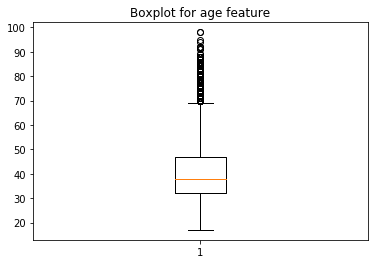

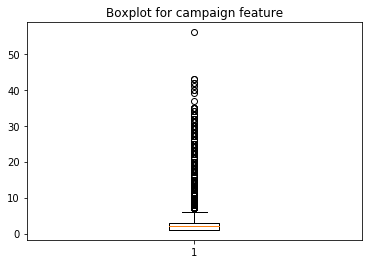

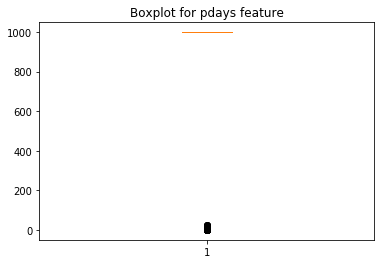

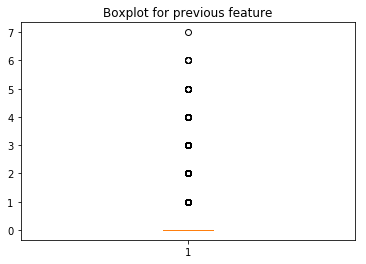

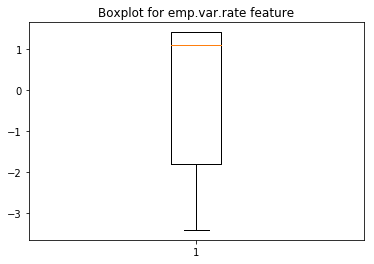

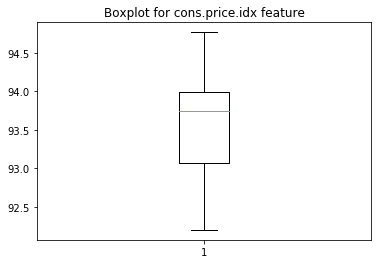

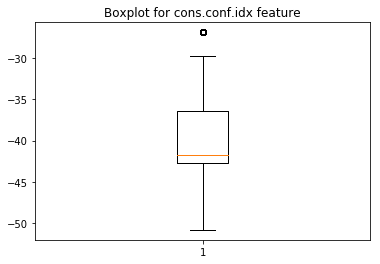

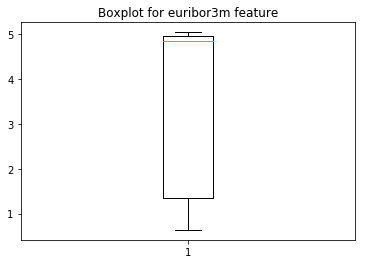

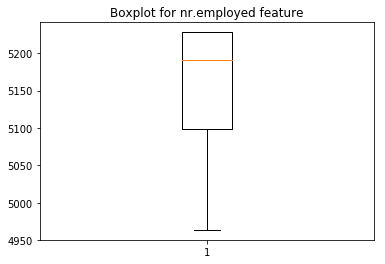

In [7]:
# Check for outliers

for x in numerical_columns:
    fig1, ax1 = plt.subplots()
    ax1.set_title(f'Boxplot for {x} feature')
    ax1.boxplot(df[x])

In [8]:
# As the used dataset eas already processed, we don't see much outliers
# Delete rows with age less than 18 as they are not eligible for a term deposit yet ':)'
# n = 5 samples

df = df[df['age'] >= 18]

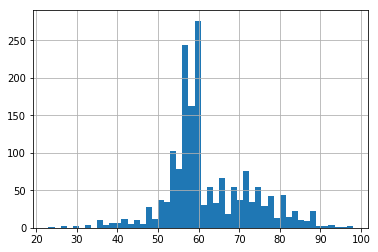

In [9]:
# Check for early retirement
df[df['job'] == 'retired'].age.hist(bins=50)

In [10]:
# Apart from workers with the special regimen of retirement -- the police, the military,etc,
# the fact that some people claimed to be retired at the age of less than 50 years old is hard to explain
# We can safely delete them from the dataset
# n = 109 samples

df = df.drop(df[(df['job'] == 'retired') & (df['age'] < 50)].index, axis=0)


In [11]:
# Process 'unknowns'


In [12]:
# The individuals with default accounts for only 3 samples, the others are 'unknown' and 'no' responses
# We can safely drop this attribute

print(df['default'].value_counts())
df[df['default'] == 'yes']
df = df.drop(['default'], axis=1)

no         32521
unknown     8550
yes            3
Name: default, dtype: int64


In [13]:
# We can supppose that job and education attributes have decent correlation
# For example, a technician is more likely to finish the professional courses than university

pd.crosstab(df.education, df.job)

job,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed,unknown
education,,,,,,,,,,,,
basic.4y,77,2318,137,474,100,561,93,132,26,58,112,52
basic.6y,151,1426,71,77,85,65,25,226,13,87,34,22
basic.9y,499,3623,210,94,166,120,220,388,96,384,186,31
high.school,3329,878,234,174,298,259,118,2682,357,873,259,37
illiterate,1,8,2,1,0,1,3,0,0,0,0,0
professional.course,363,453,135,59,89,231,168,218,43,3320,142,12
university.degree,5753,94,610,139,2063,280,765,173,170,1809,262,45
unknown,249,454,57,42,123,94,29,150,165,212,19,131


In [14]:
# We drop those samples where we can't make such proposition

df = df.drop(df[(df.education == 'unknown') & (df.job == 'unknown')].index)

In [15]:
# Find most frequent education for specific jobs
# In the form "job: education"

job_educ_groupby_table = df.groupby(['job'])['education'].apply(lambda x: x.value_counts().index[0])
job_educ_dict = {}

for x in range(len(job_educ_groupby_table)):
    job_educ_dict[job_educ_groupby_table.index[x]] = job_educ_groupby_table[x]

# Delete 'unknown' value
del job_educ_dict['unknown']

# Create dataframe for unknown education values
df_unknowns = df[df['education'] == 'unknown']

# Replace unknowns with most frequent values
for x in job_educ_dict:
    df_unknowns.loc[df_unknowns['job'] == x, 'education'] = job_educ_dict[x]
df = df_unknowns.combine_first(df)


/home/michael/.local/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [16]:
# The same thing done reversed; infer job from education



educ_job_groupby_table = df.groupby(['education'])['job'].apply(lambda x: x.value_counts().index[0])
educ_job_dict = {}

for x in range(len(educ_job_groupby_table)):
    educ_job_dict[educ_job_groupby_table.index[x]] = educ_job_groupby_table[x]

# Create dataframe for unknown job values
df_unknowns2 = df[df['job'] == 'unknown']

# Replace unknowns with most frequent values
for x in educ_job_dict:
    df_unknowns2.loc[df_unknowns2['education'] == x, 'job'] = educ_job_dict[x]
df = df_unknowns2.combine_first(df)

Socio-economic attributes

The present dataset doesn't come with assigned dates. Nevertheless, this data is real so we can use wider socio-economic context to infer. 

   First, we explore the "euribor3m" attribute that is a daily indicator of the averaged interest rate on the inter-bank market in the European Union. The lower the rate, the easier for a bank to acquire money from loan, what resulted in easier access to bank services for the population. The image below shows the Euribor rate (in the interval of 2008-2010 years) following the key interest rate set by the European Central Bank in attempt to boost the demand and start the economical recovery.
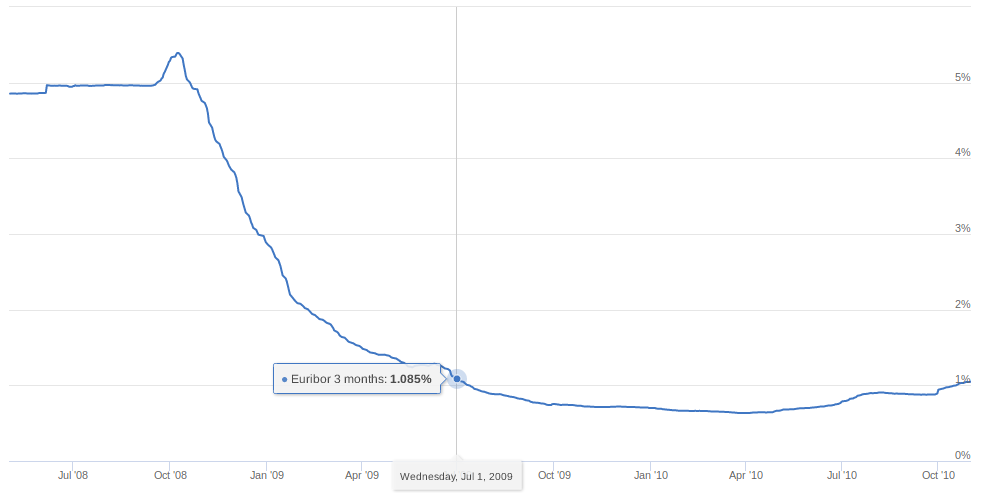

This chart helps to map the approximate dates of our calls in the dataset

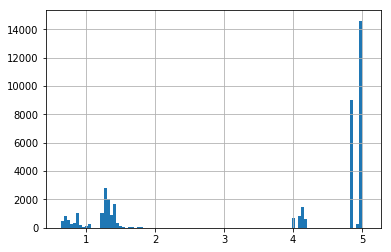

In [17]:
# The majority of calls were made from may to october 2008, when the euribor rate was around 5 %

df.euribor3m.hist(bins=100)

The economy of Portugal was hardly hit by the economical crisis of 2007-2008, and the socio-economic indeces were plummeting. The unemployment rate was rising, as the 'nr.employed' attribute shows us.

The difference between number of employed individuals (in thousands) in two dataset slices:

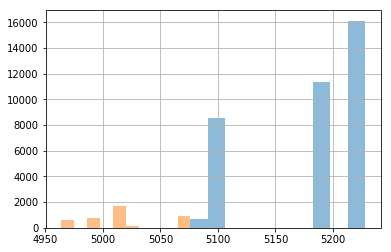

In [18]:
# Blue -- high euribor, prior to July 1, 2009
# Orange -- low euribor, after July 1, 2009

df[df['euribor3m'] > 1.1]['nr.employed'].hist(alpha=0.5)
df[df['euribor3m'] < 1.1]['nr.employed'].hist(alpha=0.5)



The suggestion is confirmed by the official state statistics:

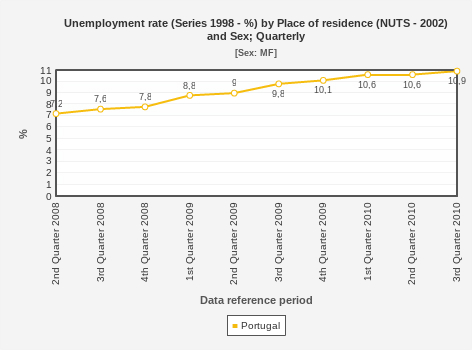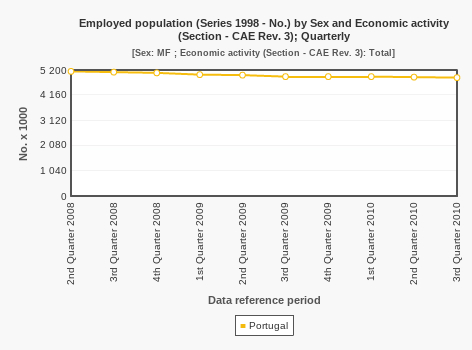



Building on this context, we could interpret dataset socio-economic attributes as pertaining to acute or non-acute phase of the crisis. July 1, 2009, with Euribor rate roughly 1.1 %, is used as the reference. All calls prior to this date are regarded to be "non-acute crisis calls", all calls after as "acute crisis calls".

In [19]:
# Add 'crisis' column based on euribor attribute. '0' means 'no crisis', '1' means 'crisis' 

conditions = [
    df['euribor3m'] > 1.1,
    df['euribor3m'] < 1.1
]
choices = [0, 1]
df['crisis'] = np.select(conditions, choices)

In [20]:
# Drop other socio-economic attributes as no longer needed

soc_econ_attrs = ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed']

df = df.drop(labels=soc_econ_attrs, axis=1) 

In [21]:
df_unproc = df

In [22]:
# Get dummy values

categorical_columns_dummy = []
for col in df.columns:
    if df[col].dtype == 'O':
        categorical_columns_dummy.append(col)

for x in categorical_columns_dummy:
    df_dum = pd.get_dummies(df[x], prefix=x)
    df= pd.concat([df, df_dum], axis=1)
df = df.drop(columns=categorical_columns_dummy, axis=1)

# Drop y_no column
df = df.drop(['y_no'], axis=1)


In [23]:
df_ohe = df
df.columns

Index(['age', 'campaign', 'pdays', 'previous', 'crisis', 'job_admin.',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'marital_divorced',
       'marital_married', 'marital_single', 'marital_unknown',
       'education_basic.4y', 'education_basic.6y', 'education_basic.9y',
       'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_university.degree',
       'housing_no', 'housing_unknown', 'housing_yes', 'loan_no',
       'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone',
       'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu',
       'day_of_week_tue', 'day_of_week_wed', 'poutcome_failure',
       'poutcome_nonexistent', 'p

In [24]:
from sklearn.model_selection import train_test_split

X = df.drop('y_yes', axis=1)
y = df['y_yes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)


In [25]:
# normalize data for T-SNE
from sklearn import preprocessing

cols = X.columns

min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
df_tsne = pd.DataFrame(np_scaled, columns = cols)

In [26]:
import time
from sklearn.manifold import TSNE


# T-SNE model 
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(df_tsne.values)
t1 = time.time()
print(f"T-SNE took {t1 - t0}-s to run")



T-SNE took 2119.7500586509705-s to run


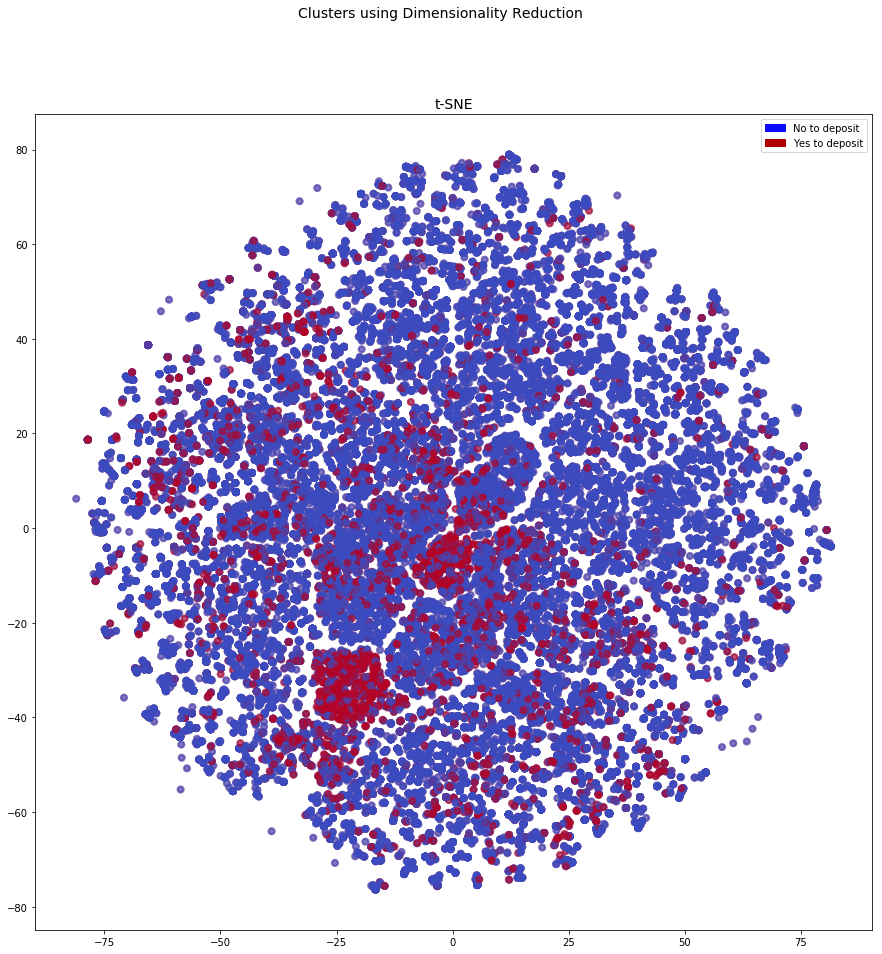

In [27]:
# Plot T-SNE
import matplotlib.patches as mpatches

f, ax1 = plt.subplots(figsize=(15,15))
# labels = ['No to deposit', 'Yes to deposit']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='No to deposit')
red_patch = mpatches.Patch(color='#AF0000', label='Yes to deposit')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(df.y_yes == 0), cmap='coolwarm', label='No to deposit', linewidths=2, alpha=0.3)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(df.y_yes == 1), cmap='coolwarm', label='Yes to deposit', linewidths=2, alpha=0.6)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(False)

ax1.legend(handles=[blue_patch, red_patch])

In [28]:
# Working with train dataset to leave test dataset untouched

In [29]:
from sklearn.model_selection import StratifiedKFold

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X_train, y_train):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X_train.iloc[train_index], X_train.iloc[test_index]
    original_ytrain, original_ytest = y_train.iloc[train_index], y_train.iloc[test_index]

Train: [ 6137  6139  6140 ... 30704 30705 30706] Test: [   0    1    2 ... 6143 6149 6171]
Train: [    0     1     2 ... 30704 30705 30706] Test: [ 6137  6139  6140 ... 12295 12299 12303]
Train: [    0     1     2 ... 30704 30705 30706] Test: [12280 12281 12282 ... 18711 18734 18738]
Train: [    0     1     2 ... 30704 30705 30706] Test: [18393 18394 18395 ... 24786 24800 24804]
Train: [    0     1     2 ... 24786 24800 24804] Test: [24545 24546 24547 ... 30704 30705 30706]


In [30]:
# Find best parameters of Random Forest with grid search

from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=42)

param_grid = { 
    'n_estimators': [50, 200, 500, 1000, 3000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [5,8],
    'min_samples_split': [2,4,6]
}

CV_rfc = GridSearchCV(rfc, param_grid=param_grid, verbose=10, n_jobs=-1, cv=4, scoring='f1')
CV_rfc.fit(original_Xtrain, original_ytrain)



Fitting 4 folds for each of 90 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed: 15.0min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed: 20.1min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed: 24.0min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed: 27

GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [50, 200, 500, 1000, 3000]},
             scoring='f1', verbose=10)

In [31]:
best_rfc_params = CV_rfc.best_params_
best_rfc = CV_rfc.best_estimator_

In [32]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline

precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

for train, test in tqdm(sss.split(original_Xtrain, original_ytrain)):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), best_rfc) # SMOTE happens during Cross Validation not before..
    model = pipeline.fit(original_Xtrain.iloc[train], original_ytrain.iloc[train])
    prediction = model.predict(original_Xtrain.iloc[test])
    
    precision_lst.append(precision_score(original_ytrain.iloc[test], prediction))
    recall_lst.append(recall_score(original_ytrain.iloc[test], prediction))
    f1_lst.append(f1_score(original_ytrain.iloc[test], prediction))
    auc_lst.append(roc_auc_score(original_ytrain.iloc[test], prediction))

5it [02:32, 30.60s/it]


In [33]:
print(auc_lst)
print(f1_lst)

[0.7366343192130627, 0.7310487948499431, 0.7135566647866607, 0.6950321878548305, 0.72463151469676]
[0.4960254372019078, 0.48281250000000003, 0.4588607594936709, 0.43118536197295154, 0.4758893280632411]


In [34]:
# Plot feature importances

df_feature_importance = pd.DataFrame(best_rfc.feature_importances_, index=X.columns, columns=['feature importance']).sort_values('feature importance', ascending=False)
df_feature_importance

,feature importance
contact_telephone,0.13603
crisis,0.09342
month_may,0.08342
pdays,0.07538
campaign,0.05441
month_jul,0.05081
month_aug,0.04550
contact_cellular,0.03996
poutcome_success,0.03982
month_nov,0.03954


In [35]:
auc_lst

[0.7366343192130627,
 0.7310487948499431,
 0.7135566647866607,
 0.6950321878548305,
 0.72463151469676]

In [36]:
y_pred = best_rfc.predict(X_test)
f1_score(y_test, y_pred)


0.46639128802102897

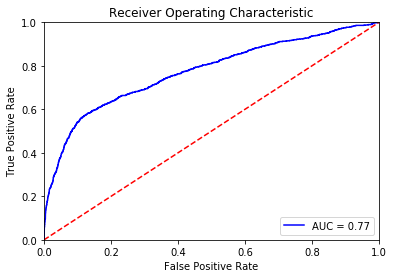

In [37]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = best_rfc.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

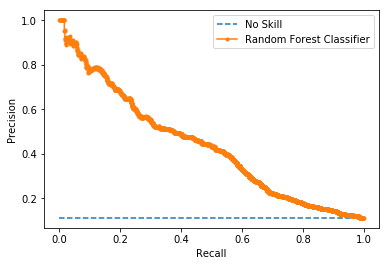

In [38]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

# predict probabilities
lr_probs = best_rfc.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# predict class values
yhat = best_rfc.predict(X_test)
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)

# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='Random Forest Classifier')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

In [39]:
df['predicted_probability'] = best_rfc.predict_proba(df_ohe.drop('y_yes', axis=1))[:, 1]

In [40]:
df.head()

,age,campaign,pdays,previous,crisis,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,...,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,y_yes,predicted_probability
0,56.00000,1.00000,999.00000,0.00000,0,0,0,0,1,0,...,0,1,0,0,0,0,1,0,0,0.20040
1,57.00000,1.00000,999.00000,0.00000,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0.14268
2,37.00000,1.00000,999.00000,0.00000,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0.14968
3,40.00000,1.00000,999.00000,0.00000,0,1,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0.22018
4,56.00000,1.00000,999.00000,0.00000,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0.14629


In [41]:
# normalized dataframe (полученный путём df_ohe = df, когда df еще был нормализован)
df_ohe.head()

,age,campaign,pdays,previous,crisis,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,...,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,y_yes,predicted_probability
0,56.00000,1.00000,999.00000,0.00000,0,0,0,0,1,0,...,0,1,0,0,0,0,1,0,0,0.20040
1,57.00000,1.00000,999.00000,0.00000,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0.14268
2,37.00000,1.00000,999.00000,0.00000,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0.14968
3,40.00000,1.00000,999.00000,0.00000,0,1,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0.22018
4,56.00000,1.00000,999.00000,0.00000,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0.14629


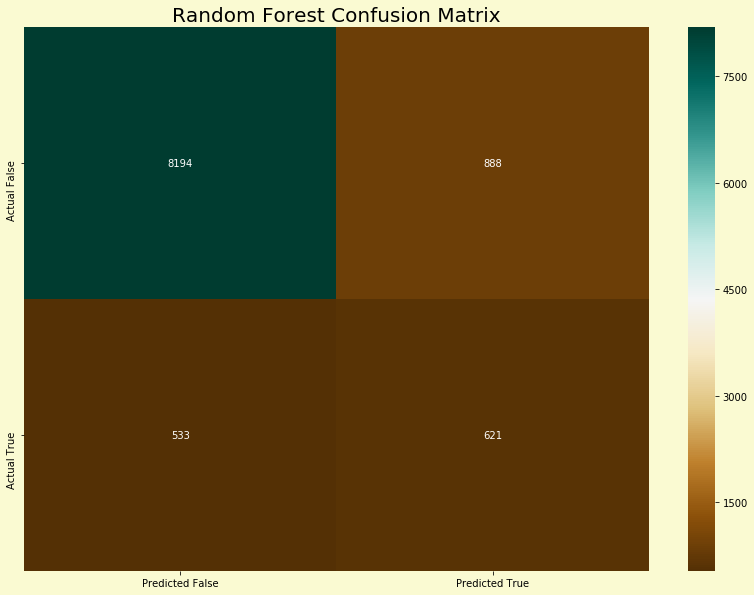

In [42]:
cf = confusion_matrix(y_test, y_pred)


fig, ax = plt.subplots(1,1, figsize=(14,10))
sns.heatmap(cf, annot = True,  cmap = plt.cm.BrBG, fmt='d', 
            xticklabels=['Predicted False', 'Predicted True'],
           yticklabels=['Actual False', 'Actual True'])
ax.set_title("Random Forest Confusion Matrix", fontsize=20)

fig.set_facecolor('lightgoldenrodyellow')

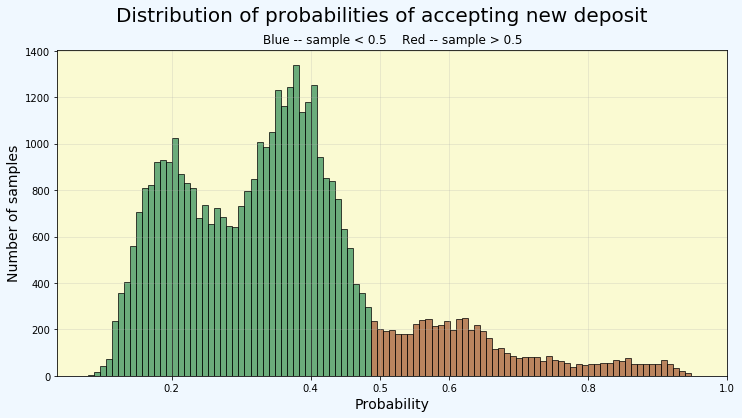

In [43]:
# Blue

fig = plt.figure(figsize=(12,6), facecolor='aliceblue')
ax = df_ohe.predicted_probability.hist(bins=100, color='sienna', edgecolor='black', linewidth=1, alpha=0.7)
for patch in ax.patches[:47]:
    patch.set_facecolor('seagreen') 

ax.set_title('Blue -- sample < 0.5' + '    ' + 'Red -- sample > 0.5', fontsize=12)
ax.set_xlabel('Probability', fontsize=14)
ax.set_ylabel('Number of samples', fontsize=14)
ax.set_facecolor('lightgoldenrodyellow')
ax.set_xticks([0.2,0.4,0.5,0.6,0.8,1.0])
fig.suptitle('Distribution of probabilities of accepting new deposit', fontsize=20)
ax.grid(alpha=0.3)

plt.show()

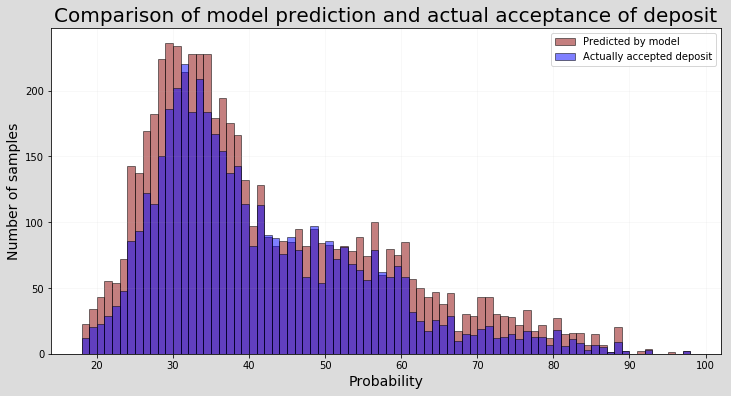

In [45]:
# predicted distribution is pretty much the same

bins_num = int(df_ohe.age.max()-df_ohe.age.min())

fig = plt.figure(figsize=(12,6), facecolor='gainsboro')
ax = df_ohe[df_ohe.predicted_probability > 0.5].age.hist(bins=bins_num, color='darkred', 
                                                     edgecolor='black', linewidth=1, alpha=0.5,
                                                        label='Predicted by model')
ax = df_ohe[df_ohe.y_yes == 1].age.hist(bins=bins_num, color='blue', 
                                        edgecolor='black', linewidth=1, alpha=0.5, 
                                        label='Actually accepted deposit')


ax.set_title('Comparison of model prediction and actual acceptance of deposit', fontsize=20)
ax.set_xlabel('Probability', fontsize=14)
ax.set_ylabel('Number of samples', fontsize=14)
ax.grid(alpha=0.1)

plt.legend()
plt.show()



In [47]:
# Only samples with model probability higher than 0.5 
yes_predicted_df = df[df_ohe['predicted_probability'] > 0.5]
len(yes_predicted_df)

5930

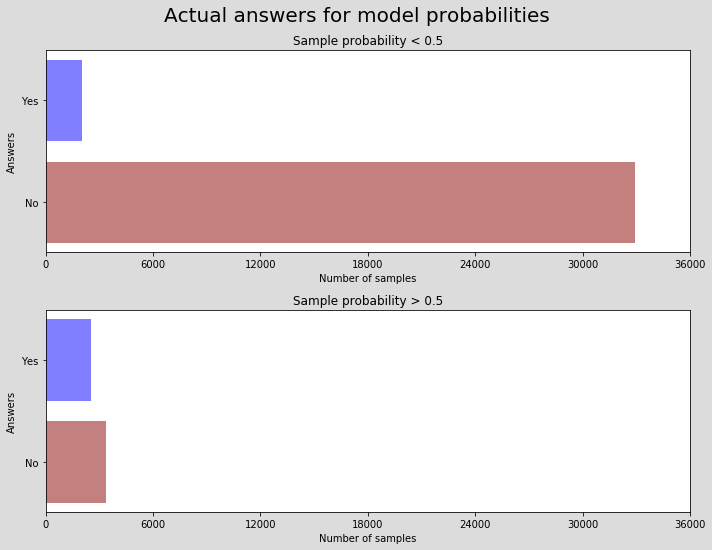

In [48]:
# Модель хорошо отсеивает TN как видно на первом графике
# Compare prob > 0.5, prob < 0.5

x1 = df[df_ohe['predicted_probability'] < 0.5].y_yes.value_counts().values
y1 = ['No', 'Yes']
x2 = df[df_ohe['predicted_probability'] > 0.5].y_yes.value_counts().values
y2 = ['No', 'Yes']

fig, ax = plt.subplots(2,1, figsize=(10,8))

fig.set_facecolor('gainsboro')
colors = {'Yes':'blue', 'No':'darkred'}

ax[0].barh(y1, x1, color=[colors[t] for t in y1], alpha=0.5)
ax[1].barh(y2, x2, color=[colors[t] for t in y2], alpha=0.5)

ax[0].set_yticks([0,1])
ax[1].set_yticks([0,1])
ax[0].set_xticks([i for i in range(0, 36001, 6000)])
ax[1].set_xticks([i for i in range(0, 36001, 6000)])

ax[0].set_title('Sample probability < 0.5', fontsize=12)
ax[1].set_title('Sample probability > 0.5', fontsize=12)

ax[0].set_xlabel('Number of samples')
ax[1].set_xlabel('Number of samples')
ax[0].set_ylabel('Answers')
ax[1].set_ylabel('Answers')

fig.suptitle('Actual answers for model probabilities', fontsize=20)


fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.subplots_adjust()
plt.show()


In [49]:
# Разобъем соотношение возраста и профессии на три группы: 18-30 лет, 30-60 лет и 60+ лет.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


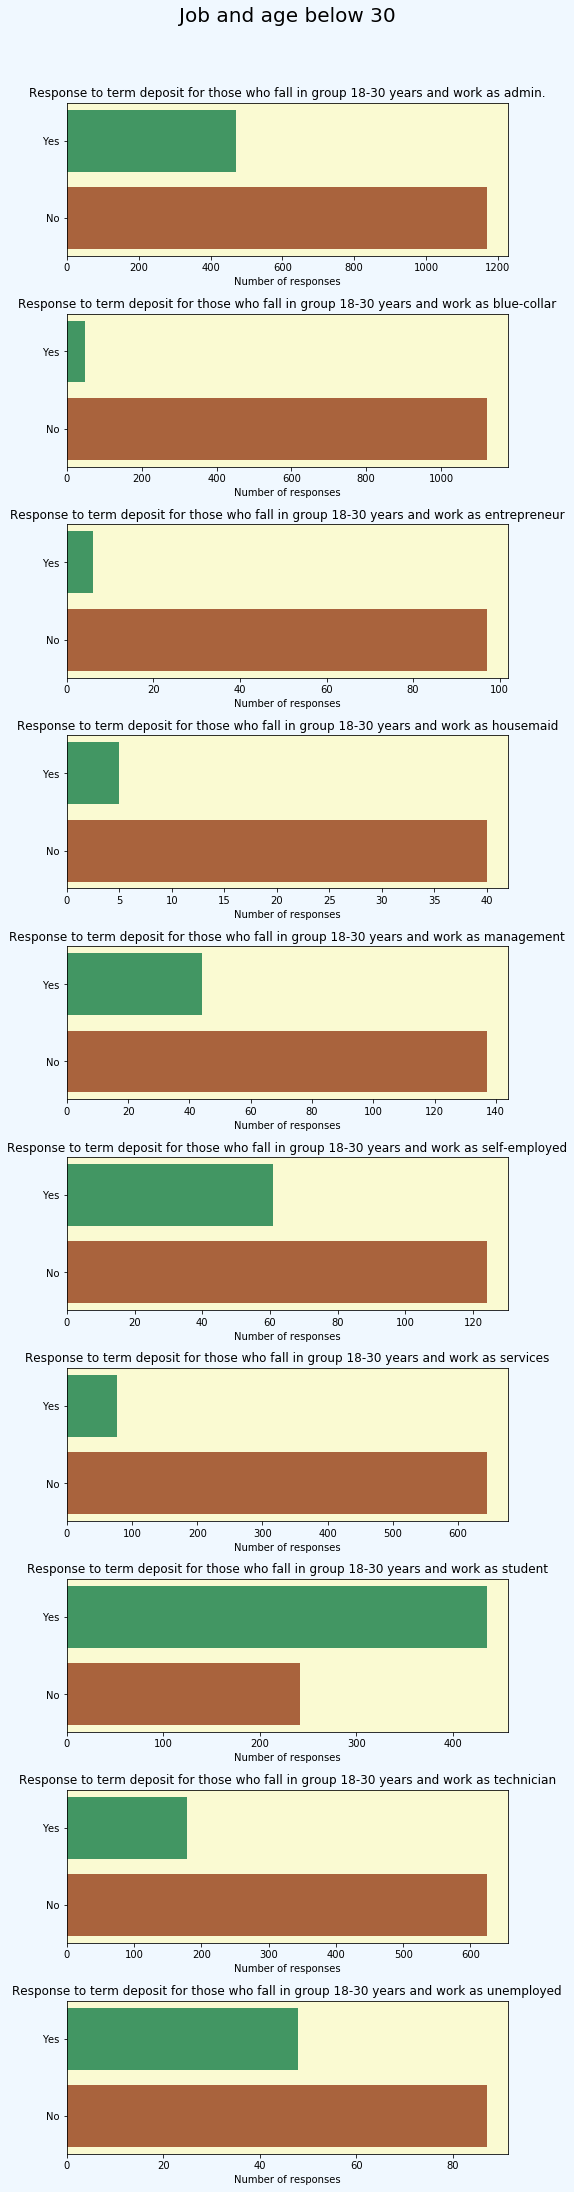

In [50]:
# 18-30
job_cols = ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management',  'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed']

fig, axes = plt.subplots(10,1, figsize = (8, 32))

count = 0
for ax in axes.flat:
    j_no= df_ohe[(df_ohe['predicted_probability'] < 0.5) & (df_ohe['age'] < 30)][job_cols[count]].value_counts(sort=False)
    j_yes = yes_predicted_df[(df_ohe['age'] < 30)][job_cols[count]].value_counts(sort=False)
    
    # Make data for charts
    x_ax = ['No', 'Yes']
    try:
        y_ax1 = j_no.values[1]
    except IndexError:
        y_ax1 = 0
    
    try:
        y_ax2 = j_yes.values[1]
    except IndexError:
        y_ax2 = 0
    
    y_ax = []
    y_ax.append(y_ax1)
    y_ax.append(y_ax2)
    
        
    # Plot chart
    colors = {'Yes':'seagreen', 
              'No':'sienna'}
    ax.barh(x_ax, y_ax , alpha=0.9, color=[colors[t] for t in x_ax])
    
    # Tune settings
    ax.set_title(f'Response to term deposit for those who fall in group 18-30 years and work as {job_cols[count][4:]}')
    ax.set_xlabel('Number of responses')
    ax.set_facecolor('lightgoldenrodyellow')
    
    count+= 1

fig.suptitle('Job and age below 30', fontsize=20)
fig.set_facecolor('aliceblue')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.subplots_adjust()
plt.show()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


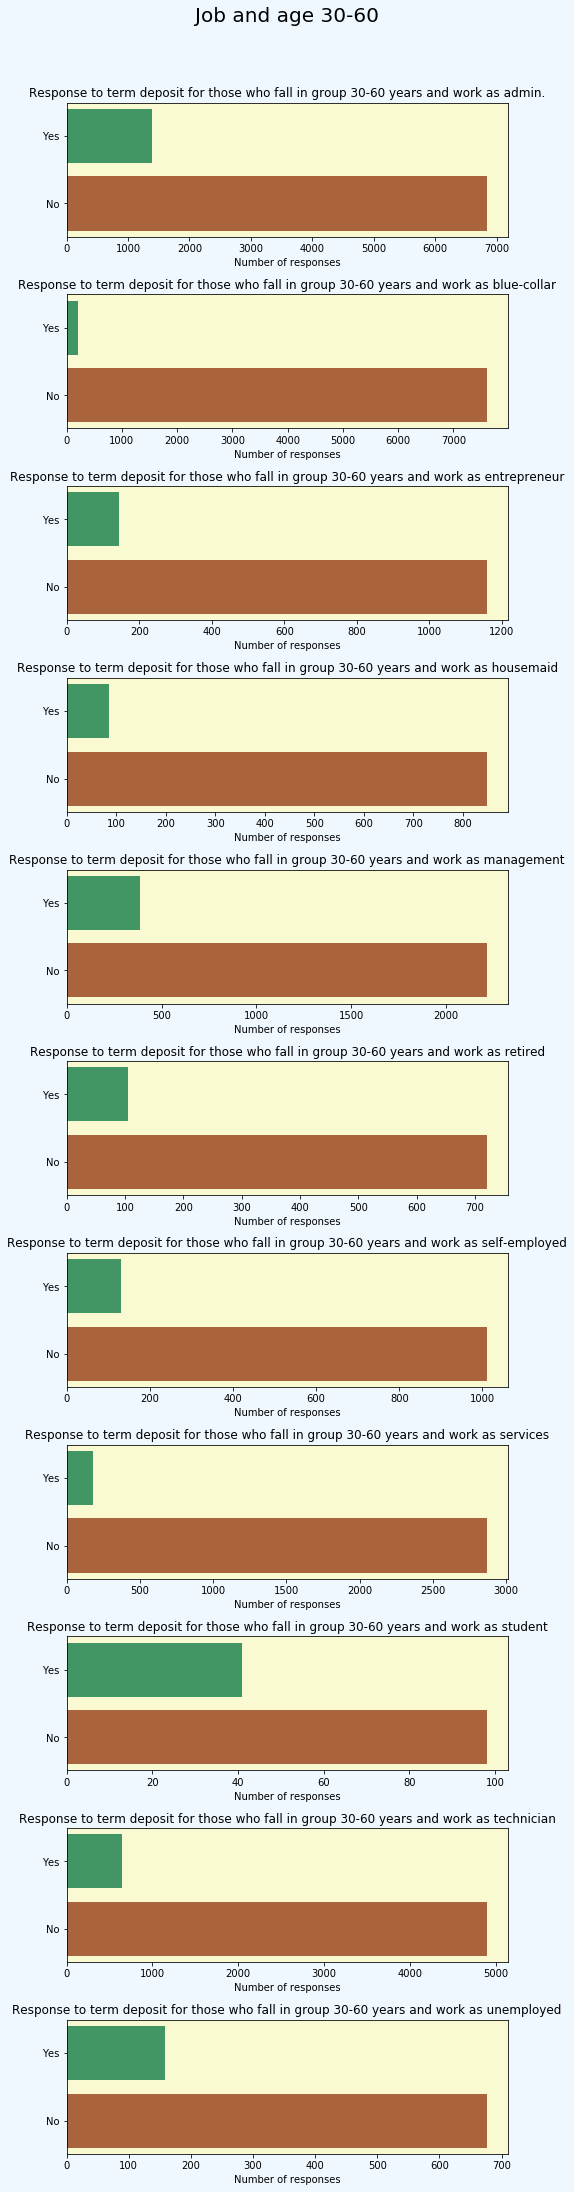

In [51]:
# 30-60

job_cols = ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management',  'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed']

fig, axes = plt.subplots(11,1, figsize = (8, 32))

count = 0
for ax in axes.flat:
    j_no= df_ohe[(df_ohe['predicted_probability'] < 0.5) & ((df_ohe['age'] < 60) & (df_ohe['age'] > 30))][job_cols[count]].value_counts(sort=False)
    j_yes = yes_predicted_df[((df_ohe['age'] < 60) & (df_ohe['age'] > 30))][job_cols[count]].value_counts(sort=False)
    
    # Make data for charts
    x_ax = ['No', 'Yes']
    try:
        y_ax1 = j_no.values[1]
    except IndexError:
        y_ax1 = 0
    
    try:
        y_ax2 = j_yes.values[1]
    except IndexError:
        y_ax2 = 0
    
    y_ax = []
    y_ax.append(y_ax1)
    y_ax.append(y_ax2)
    
        
    # Plot chart
    colors = {'Yes':'seagreen', 
              'No':'sienna'}
    ax.barh(x_ax, y_ax , alpha=0.9, color=[colors[t] for t in x_ax])
    
    # Tune settings
    ax.set_title(f'Response to term deposit for those who fall in group 30-60 years and work as {job_cols[count][4:]}')
    ax.set_xlabel('Number of responses')
    ax.set_facecolor('lightgoldenrodyellow')
    
    count+= 1

fig.suptitle('Job and age 30-60', fontsize=20)
fig.set_facecolor('aliceblue')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.subplots_adjust()
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


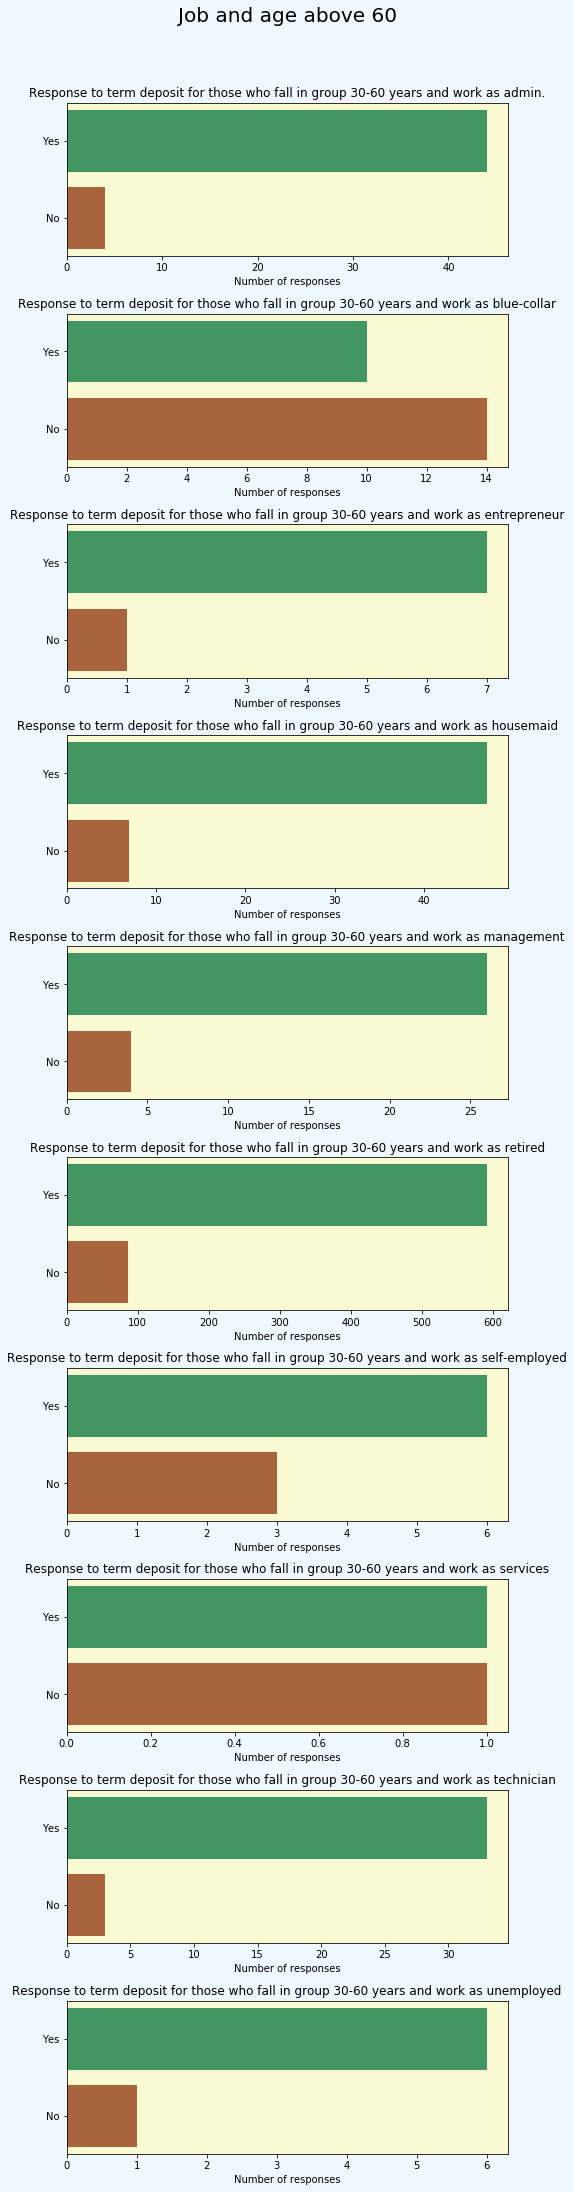

In [52]:
# 60+

job_cols = ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management',  'job_retired', 'job_self-employed', 'job_services',
            'job_technician', 'job_unemployed']

fig, axes = plt.subplots(10,1, figsize = (8, 32))

count = 0
for ax in axes.flat:
    j_no= df_ohe[(df_ohe['predicted_probability'] < 0.5) & (df_ohe['age'] > 60)][job_cols[count]].value_counts(sort=False)
    j_yes = yes_predicted_df[(df_ohe['age'] > 60)][job_cols[count]].value_counts(sort=False)
    
    # Make data for charts
    x_ax = ['No', 'Yes']
    try:
        y_ax1 = j_no.values[1]
    except IndexError:
        y_ax1 = 0
    
    try:
        y_ax2 = j_yes.values[1]
    except IndexError:
        y_ax2 = 0
    
    y_ax = []
    y_ax.append(y_ax1)
    y_ax.append(y_ax2)
    
        
    # Plot chart
    colors = {'Yes':'seagreen', 
              'No':'sienna'}
    ax.barh(x_ax, y_ax , alpha=0.9, color=[colors[t] for t in x_ax])
    
    # Tune settings
    ax.set_title(f'Response to term deposit for those who fall in group 30-60 years and work as {job_cols[count][4:]}')
    ax.set_xlabel('Number of responses')
    ax.set_facecolor('lightgoldenrodyellow')
    
    count+= 1

fig.suptitle('Job and age above 60', fontsize=20)
fig.set_facecolor('aliceblue')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.subplots_adjust()
plt.show()

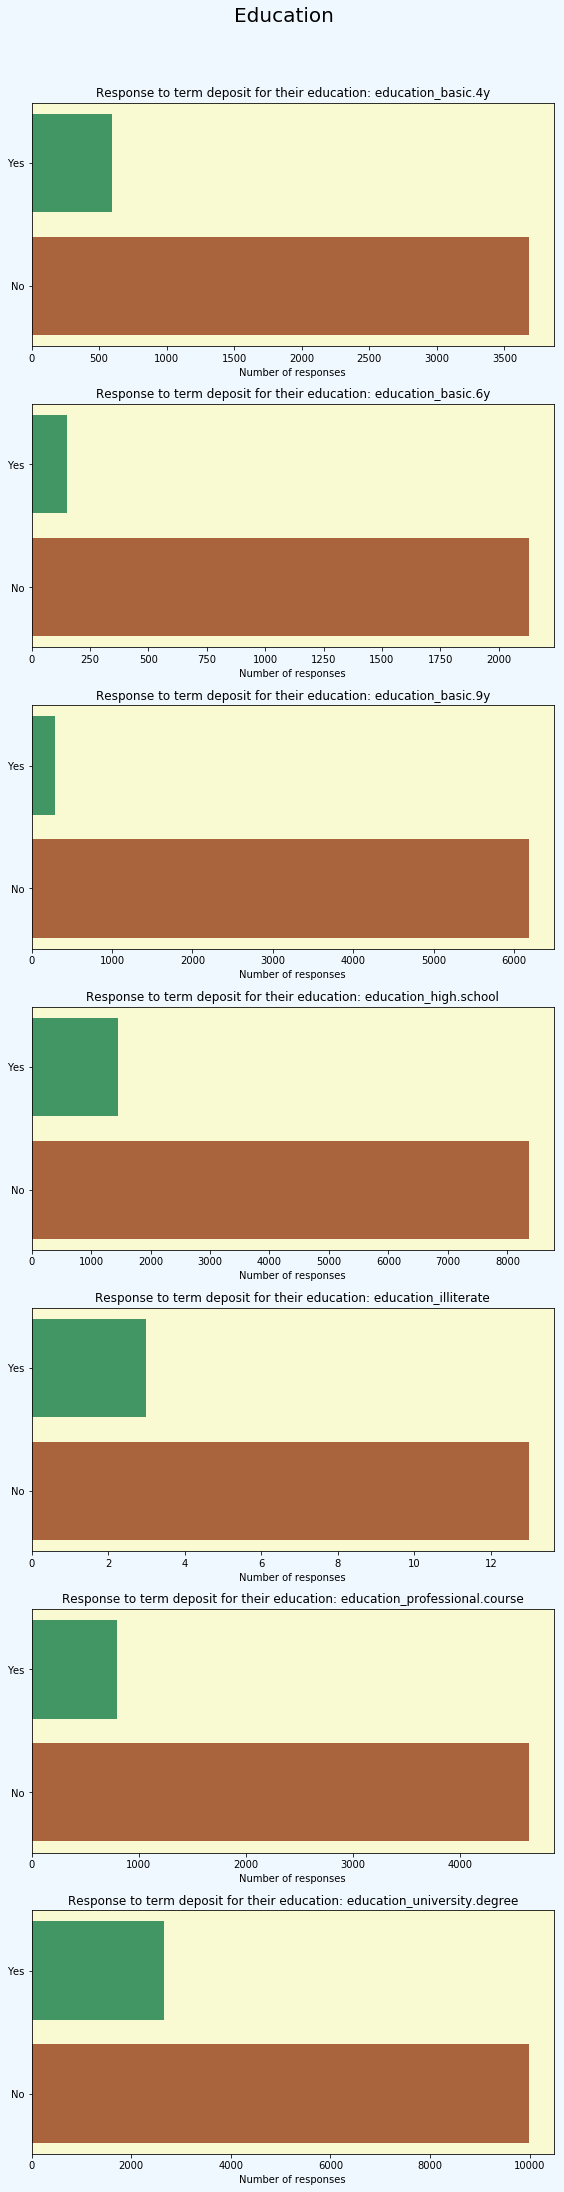

In [55]:
educat_cols= ['education_basic.4y', 'education_basic.6y',
       'education_basic.9y', 'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_university.degree']

fig, axes = plt.subplots(len(educat_cols),1, figsize = (8, 32))

count = 0
for ax in axes.flat:
    
    # Using sample(df) to compare equal shares
    j_no= df_ohe[df_ohe['predicted_probability'] < 0.5][educat_cols[count]].value_counts(sort=False)
    j_yes = yes_predicted_df[educat_cols[count]].value_counts(sort=False)
    
    # Make data for charts
    x_ax = ['No', 'Yes']
  # Conditions to avoid situations when value_counts() doesn't return value, because it's absent in the dataframe
    if len(j_no.values) == 1 & len(j_yes.values) == 1:
        continue 
    elif len(j_no.values) == 1:
        y_ax = 0 ,j_yes.values[1]
    elif len(j_yes.values) == 1:
        y_ax = j_no.values[1], 0  
    else:
        y_ax = j_no.values[1],j_yes.values[1]
    
    
        
    # Plot chart
    colors = {'Yes':'seagreen', 
              'No':'sienna'}
    ax.barh(x_ax, y_ax , alpha=0.9, color=[colors[t] for t in x_ax])
    
    # Tune settings
    ax.set_title(f'Response to term deposit for their education: {educat_cols[count]}')
    ax.set_xlabel('Number of responses')
    ax.set_facecolor('lightgoldenrodyellow')
    
    count+= 1

fig.suptitle('Education', fontsize=20)
fig.set_facecolor('aliceblue')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.subplots_adjust()
plt.show()

Model wasn't able to find that those who had previous experience with the bank are more likely to accept term deposit.

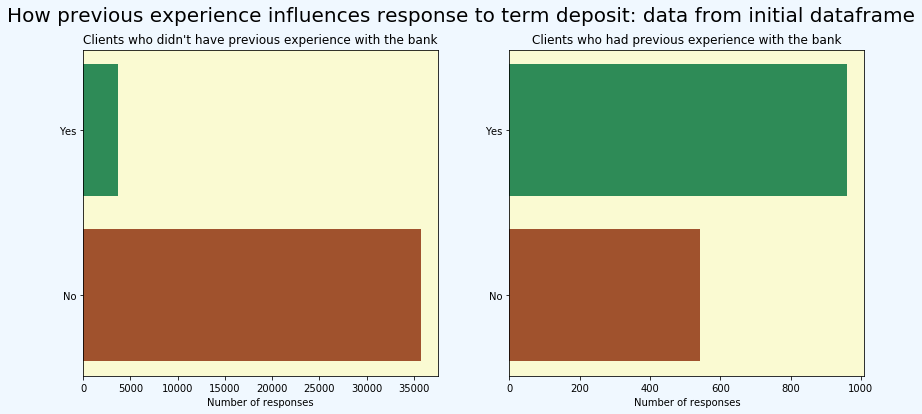

In [103]:
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(1,2,1)
bx = fig.add_subplot(1,2,2)

absent_contact_no = df_ohe[(df_ohe['pdays'] == 999) & (df_ohe['y_yes'] == 0)].pdays
absent_contact_yes = df_ohe[(df_ohe['pdays'] == 999) & (df_ohe['y_yes'] == 1)].pdays

had_contact_yes = df_ohe[(df_ohe['pdays'] < 999) & (df_ohe['y_yes'] == 1)].pdays
had_contact_no = df_ohe[(df_ohe['pdays'] < 999) & (df_ohe['y_yes'] == 0)].pdays

# Plot chart
colors = {'Yes':'seagreen', 'No':'sienna'}
x_ax = ['No', 'Yes']
ax.barh(x_ax, [len(absent_contact_no), len(absent_contact_yes)], color=[colors[t] for t in x_ax])
bx.barh(x_ax, [len(had_contact_no), len(had_contact_yes)], color=[colors[t] for t in x_ax])

# Tune axes settings
ax.set_title("Clients who didn't have previous experience with the bank")
bx.set_title("Clients who had previous experience with the bank")
ax.set_xlabel('Number of responses')
bx.set_xlabel('Number of responses')
ax.set_facecolor('lightgoldenrodyellow')
bx.set_facecolor('lightgoldenrodyellow')

# Tune figure settings
fig.suptitle('How previous experience influences response to term deposit: data from initial dataframe', fontsize=20)
fig.set_facecolor('aliceblue')
fig.subplots_adjust()

plt.show()

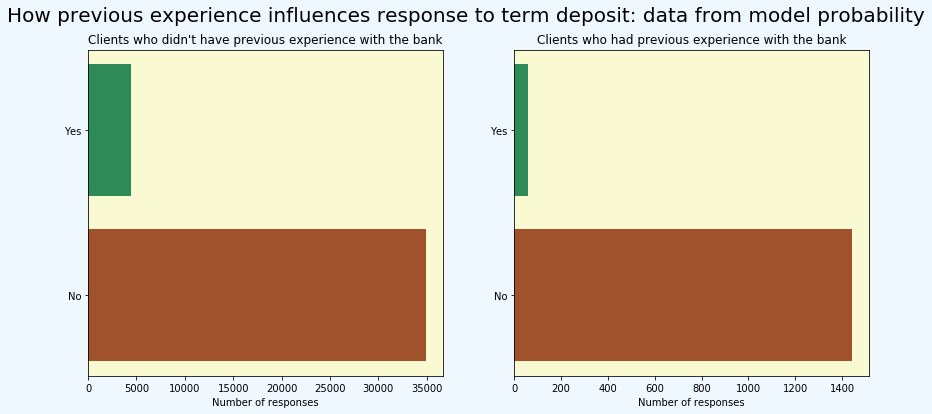

In [136]:
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(1,2,1)
bx = fig.add_subplot(1,2,2)

absent_contact_no = df_ohe[(df_ohe['pdays'] == 999) & (df_ohe['predicted_probability'] < 0.5)].pdays
absent_contact_yes = df_ohe[(df_ohe['pdays'] == 999) & (df_ohe['predicted_probability'] > 0.5)].pdays

had_contact_yes = df_ohe[(df_ohe['pdays'] < 999) & (df_ohe['predicted_probability'] < 0.5)].pdays
had_contact_no = df_ohe[(df_ohe['pdays'] < 999) & (df_ohe['predicted_probability'] > 0.5)].pdays

# Plot chart
colors = {'Yes':'seagreen', 'No':'sienna'}
x_ax = ['No', 'Yes']
ax.barh(x_ax, [len(absent_contact_no), len(absent_contact_yes)], color=[colors[t] for t in x_ax])
bx.barh(x_ax, [len(had_contact_no), len(had_contact_yes)], color=[colors[t] for t in x_ax])

# Tune axes settings
ax.set_title("Clients who didn't have previous experience with the bank")
bx.set_title("Clients who had previous experience with the bank")
ax.set_xlabel('Number of responses')
bx.set_xlabel('Number of responses')
ax.set_facecolor('lightgoldenrodyellow')
bx.set_facecolor('lightgoldenrodyellow')

# Tune figure settings
fig.suptitle('How previous experience influences response to term deposit: data from model probability', fontsize=20)
fig.set_facecolor('aliceblue')
fig.subplots_adjust()

plt.show()

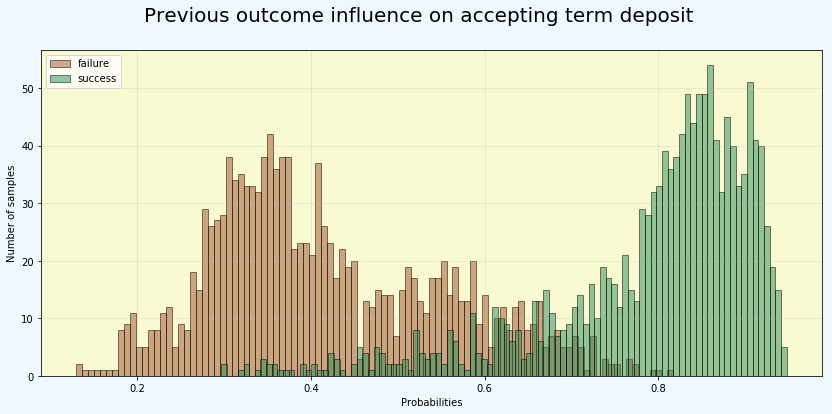

In [157]:
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(1,1,1)
ax.set_facecolor('lightgoldenrodyellow')
ax.set_xlabel('Probabilities')
ax.set_ylabel('Number of samples')
ax.grid(alpha=0.3)


# Влияет ли успех предыдущего взаимодействия на accepting term deposit
# Let's take samples from 'previous outcome failure' and 'previous outcome success'
success_and_yes = df_ohe[(df_ohe['poutcome_success'] == 1)]
# There are more 'previous outcome failure' samples in initial dataset, so we take sample
# size of equal amount
df_ohe[(df_ohe['poutcome_failure'] == 1)].sample(len(success_and_yes)).predicted_probability.hist(bins=100, 
                                                                                                  alpha=0.5, 
                                                                                                  label='failure', 
                                                                                                  color='sienna', 
                                                                                                  edgecolor='black')
success_and_yes.predicted_probability.hist(bins=100, 
                                           alpha=0.5, 
                                           label = 'success', 
                                           color='seagreen', 
                                           edgecolor='black')

plt.legend()
fig.suptitle('Previous outcome influence on accepting term deposit', fontsize=20)
fig.set_facecolor('aliceblue')
fig.subplots_adjust()

# If previous outcome is successful clients are more likely to accept term deposit 

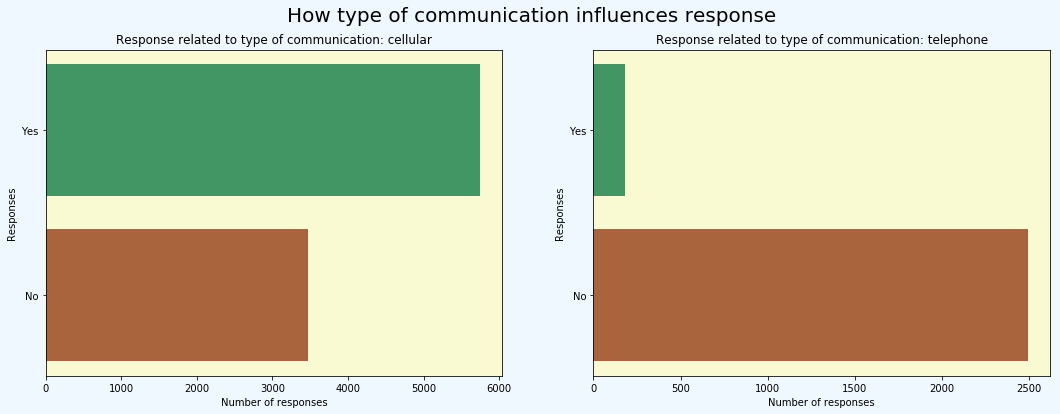

In [176]:
# по мобиле круче
fig, axes = plt.subplots(1,2, figsize = (18, 6))

contact_type = ['contact_cellular', 'contact_telephone']

count = 0
for ax in axes.flat:
    j_yes = yes_predicted_df[contact_type[count]].value_counts(sort=False)
    j_no = df_ohe[(df_ohe['predicted_probability'] < 0.5)].sample(len(yes_predicted_df[contact_type[count]]))[contact_type[count]].value_counts(sort=False)
    
    x_ax = ['No', 'Yes']
    y_ax = j_no.values[1],j_yes.values[1]
    colors = {'No':'sienna', 'Yes':'seagreen'}
    ax.barh(x_ax, y_ax, alpha=0.9, color=[colors[t] for t in x_ax])
    
    
    # Tune settings
    ax.set_xlabel('Number of responses')
    ax.set_ylabel('Responses')
    ax.set_title(f'Response related to type of communication: {contact_type[count][8:]}')
    ax.set_facecolor('lightgoldenrodyellow')
    
    count += 1

    
# Tune figure settings
fig.suptitle('How type of communication influences response', fontsize=20)
fig.set_facecolor('aliceblue')
fig.subplots_adjust()
plt.show()
    
# But why?

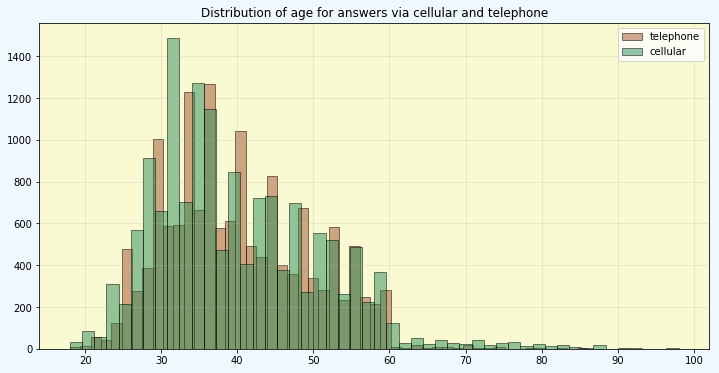

In [183]:
# Может по телефону отвечают только старики?

fig, ax = plt.subplots(figsize=(12,6))


df_ohe[df_ohe['contact_telephone'] == 1].age.hist(bins=50, 
                                           alpha=0.5, 
                                           label = 'telephone', 
                                           color='sienna', 
                                           edgecolor='black')
# sample() for equal sample size
df_ohe[df_ohe['contact_cellular'] == 1].sample(len(df_ohe[df_ohe['contact_telephone'] == 1])).age.hist(bins=50, 
                                           alpha=0.5, 
                                           label = 'cellular', 
                                           color='seagreen', 
                                           edgecolor='black')
plt.legend()
ax.set_title('Distribution of age for answers via cellular and telephone')
ax.set_facecolor('lightgoldenrodyellow')
ax.grid(alpha=0.3)
fig.set_facecolor('aliceblue')

# No, the distributions are pretty much the same

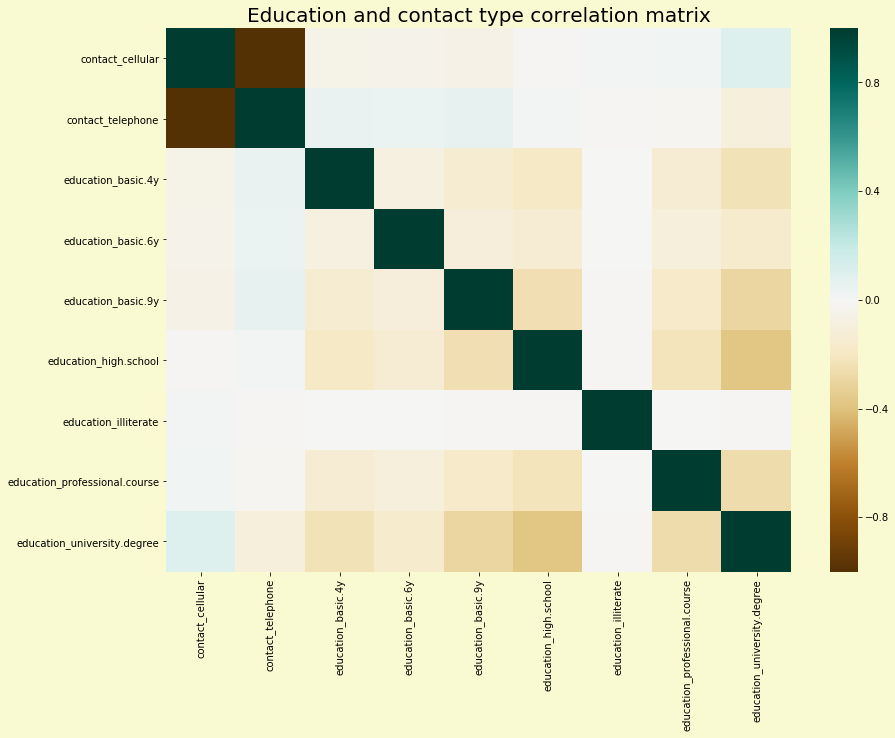

In [190]:
fig, ax = plt.subplots(1,1, figsize=(14,10))
sns.heatmap(df_ohe.loc[:, contact_type + educat_cols].corr(), cmap=plt.cm.BrBG, square=False)
ax.set_title("Education and contact type correlation matrix", fontsize=20)
fig.set_facecolor('lightgoldenrodyellow')

# Базовое образование == телефон
# Университетская степень == мобильный

# Нужно не звонить на мобильный, а искать образованых клиентов

